In [26]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, mean_squared_error, classification_report
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, chi2, f_classif

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

In [2]:
#specify CSV path
csv_path = '../Preprocessing/data_tokenized.csv'

#creating a df from the file
data = pd.read_csv(csv_path)

data.head(5)

,text,rating_overall
0,"['location', 'attention', 'detail', 'size', 'r...",5.0
1,"['dissapointedwonderful', 'bed', 'beautiful', ...",5.0
2,"['nice', 'property', 'staff', 'professional', ...",5.0
3,"['best', 'hotel', 'ever', 'lived', 'lived', 'm...",5.0
4,"['highly', 'recommend', 'stay', 'best', 'weste...",5.0


In [3]:
data['rating_overall'] = data['rating_overall'].replace(range(0, 3), 'aNegative')
data['rating_overall'] = data['rating_overall'].replace(3, 'bNeutral')
data['rating_overall'] = data['rating_overall'].replace(range(4, 6), 'cPositive')

result = data.groupby('rating_overall').size()

result

rating_overall
aNegative     3151
bNeutral      3812
cPositive    36607
dtype: int64

In [4]:
from sklearn.utils import resample

# Count the number of samples in each class
class_counts = data['rating_overall'].value_counts()
print("Class counts before downsampling:")
print(class_counts)

# Separate the classes
neutral_data = data[data['rating_overall'] == 'bNeutral']
positive_data = data[data['rating_overall'] == 'cPositive']
negative_data = data[data['rating_overall'] == 'aNegative']

# Downsample the cPositive class to match the size of bNeutral
positive_data_downsampled = resample(
    positive_data,
    replace=False,  # Do not sample with replacement
    n_samples=len(neutral_data),  # Match the size of the bNeutral class
    random_state=42  # For reproducibility
)

# Combine the downsampled cPositive class with the other classes
data_balanced = pd.concat([neutral_data, positive_data_downsampled, negative_data])

# Shuffle the dataset
data_balanced = data_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Verify the class distribution after downsampling
print("Class counts after downsampling:")
print(data_balanced['rating_overall'].value_counts())

Class counts before downsampling:
rating_overall
cPositive    36607
bNeutral      3812
aNegative     3151
Name: count, dtype: int64
Class counts after downsampling:
rating_overall
bNeutral     3812
cPositive    3812
aNegative    3151
Name: count, dtype: int64


In [5]:
words=data_balanced['text'].str.split(expand=True).stack().value_counts()
words

'room',            5422
'hotel',           4038
'location',        2459
'staff',           2374
'\n',              2258
                   ... 
['capital',           1
'washinton',          1
'refurbisheda',       1
'agenot',             1
'meritage']           1
Name: count, Length: 14273, dtype: int64

In [6]:
word_freq = {}
for word in words:
    if word in word_freq:
        word_freq[word] += 1
    else:
        word_freq[word] = 1

print(word_freq)

{5422: 1, 4038: 1, 2459: 1, 2374: 1, 2258: 1, 2226: 1, 1927: 1, 1908: 1, 1575: 1, 1508: 1, 1439: 1, 1429: 2, 1201: 1, 1158: 1, 1044: 1, 1009: 1, 995: 1, 949: 1, 890: 1, 870: 1, 840: 1, 694: 1, 654: 1, 646: 1, 643: 1, 642: 1, 638: 2, 619: 1, 610: 1, 593: 1, 547: 1, 526: 1, 523: 1, 501: 1, 480: 1, 475: 1, 461: 1, 448: 1, 447: 1, 442: 1, 436: 1, 426: 1, 425: 1, 423: 1, 416: 1, 414: 1, 394: 1, 393: 1, 392: 1, 380: 1, 356: 1, 352: 2, 348: 1, 347: 1, 344: 2, 332: 1, 329: 1, 328: 2, 326: 1, 321: 1, 319: 1, 318: 1, 309: 1, 305: 2, 302: 1, 298: 1, 292: 1, 287: 1, 286: 1, 280: 1, 273: 1, 272: 1, 260: 1, 258: 1, 254: 1, 251: 1, 250: 1, 249: 1, 248: 1, 247: 1, 246: 1, 244: 1, 242: 1, 240: 1, 239: 2, 238: 1, 233: 1, 230: 1, 229: 2, 228: 1, 223: 1, 221: 1, 220: 2, 216: 1, 212: 3, 209: 2, 208: 1, 205: 2, 204: 2, 203: 1, 199: 2, 194: 2, 192: 2, 191: 1, 190: 1, 189: 1, 187: 3, 186: 2, 185: 2, 184: 1, 183: 1, 180: 2, 178: 1, 175: 1, 174: 2, 173: 1, 172: 2, 171: 3, 170: 1, 168: 1, 167: 1, 165: 1, 163: 1,

In [7]:
def build_document_term_matrix(data_balanced):
    """
    Builds a Bag-of-Words document-term matrix.
    Returns:
    - document_term_matrix (list of lists): BoW representation of documents
    - vocab (list): Sorted vocabulary of unique words
    - word_to_index (dict): Mapping of word → index in vocabulary
    """
    # 1. Extract unique vocabulary from the dataset and sort it
    # Get all unique words from the 'text' column of the DataFrame
    vocab = sorted(set(word for doc in data_balanced['text'] for word in doc.split())) 
    
    # 2. Create a word-to-index mapping
    word_to_index = {word: idx for idx, word in enumerate(vocab)}

    print(word_to_index)

    # 3. Convert each document into a vector
    document_term_matrix = []
    
    # Iterate through the 'text' column of the DataFrame
    for doc in data_balanced['text']:
        doc_vector = [0] * len(vocab)  # Initialize a vector of zeros
        for token in doc.split(): # Split the document into tokens
            if token in word_to_index:
                doc_vector[word_to_index[token]] += 1  # Increment word count
        document_term_matrix.append(doc_vector)

    print(f"\nVocabulary Size: {len(vocab)} | Number of Documents: {len(document_term_matrix)}\n")
    # Print vectors for first two sentences 
    for i, vector in enumerate(document_term_matrix[:2]):
        print(f"Document {i} vector:\n{vector}\n")
        # Access the document text using .iloc to get the row by index
        print(f"Document {i} text:\n{data_balanced['text'].iloc[i]}\n\n{'#'*50}\n") 

    # Optionally, we can inspect the shape of our document-term matrix
    print(f"Number of documents: {len(document_term_matrix)}")
    print(f"Vocabulary size: {len(vocab)}")

    return document_term_matrix, vocab, word_to_index

document_term_matrix, vocab, word_to_index = build_document_term_matrix(data_balanced)



{"'": 0, "',": 1, "'0',": 2, "'02',": 3, "'0330',": 4, "'04',": 5, "'042905',": 6, "'0430',": 7, "'043005',": 8, "'05',": 9, "'0700',": 10, "'0700am',": 11, "'09',": 12, "'1',": 13, "'1']": 14, "'10',": 15, "'10']": 16, "'100',": 17, "'100']": 18, "'1000',": 19, "'10000',": 20, "'100150',": 21, "'1003',": 22, "'100amnot',": 23, "'100lobby',": 24, "'100night',": 25, "'100room',": 26, "'101',": 27, "'1014',": 28, "'102',": 29, "'102611',": 30, "'102711',": 31, "'1045']": 32, "'105',": 33, "'1050']": 34, "'106',": 35, "'106th',": 36, "'107',": 37, "'107th',": 38, "'108',": 39, "'109',": 40, "'1095',": 41, "'1099',": 42, "'109night',": 43, "'10day',": 44, "'10is',": 45, "'10k',": 46, "'10miles',": 47, "'10min',": 48, "'10minute',": 49, "'10minutesubwayride',": 50, "'10soif',": 51, "'10th',": 52, "'11',": 53, "'11']": 54, "'110',": 55, "'1100',": 56, "'1102',": 57, "'1118',": 58, "'1128',": 59, "'1130',": 60, "'115',": 61, "'1150',": 62, "'116',": 63, "'119',": 64, "'11c',": 65, "'11day',":

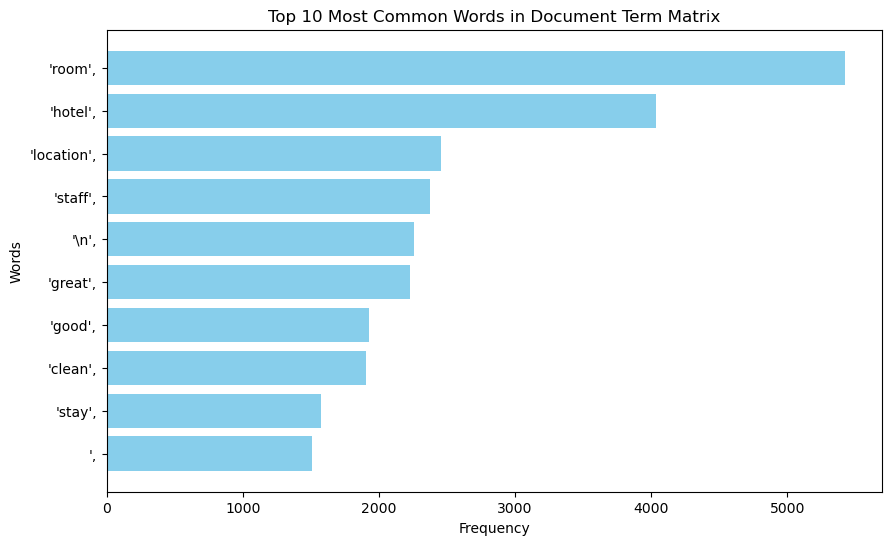

In [8]:

def visualize_top_n_tokens(n, document_term_matrix):

    # Sum the occurrences of each word across all documents
    word_counts = np.sum(document_term_matrix, axis=0)

    # Get the indices of the top n most common words
    top_n_indices = np.argsort(word_counts)[-n:]

    # Get the corresponding words and their counts
    top_n_words = [vocab[i] for i in top_n_indices]
    top_n_counts = word_counts[top_n_indices]

    # Create the bar chart
    plt.figure(figsize=(10, 6))
    plt.barh(top_n_words, top_n_counts, color='skyblue')
    plt.xlabel('Frequency')
    plt.ylabel('Words')
    plt.title(f'Top {n} Most Common Words in Document Term Matrix')
    plt.show()

visualize_top_n_tokens(10, document_term_matrix)

## Building the model

In [40]:
label_map = {
    0: 'Negative',
    1: 'Neutral',
    2: 'Positive'
}

In [41]:
(
    
    X_train,
    X_val,
    y_train,
    y_val

) = train_test_split(data_balanced["text"], data_balanced["rating_overall"], test_size=0.2, random_state=42)

print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(8620,) (2155,) (8620,) (2155,)


In [42]:
# countvectorizer
cv = CountVectorizer()
X_train_vectorized = cv.fit_transform(X_train)

X_train_vectorized.todense()

matrix([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], shape=(8620, 9817))

In [43]:
# Define pipeline
pipeline = Pipeline([
    ('logreg', LogisticRegression()),
])


# Define parameters for grid search
parameters = {
    'logreg__C': [0.1, 1.0, 10.0],
    'logreg__max_iter': [10000],
    'logreg__solver': ['saga'],
}


# Create grid search object
grid_search = GridSearchCV(pipeline, parameters, scoring='f1_weighted', cv=5, n_jobs=-1)


# Fit the grid search to the training data
#grid_search.fit(X_train, y_train)
grid_search.fit(X_train_vectorized, y_train)


# Print best parameters and score
print("Best parameters: ", grid_search.best_params_)
print("Best accuracy score: ", grid_search.best_score_)

Best parameters:  {'logreg__C': 0.1, 'logreg__max_iter': 10000, 'logreg__solver': 'saga'}
Best accuracy score:  0.7248740622245865


In [44]:
# Extract the best parameters from grid_search
best_params = grid_search.best_params_

# Create a LogisticRegression model using the best parameters
lr = LogisticRegression(
    C=best_params['logreg__C'],
    max_iter=best_params['logreg__max_iter'],
    solver=best_params['logreg__solver']
)

In [46]:
lr.fit(X_train_vectorized, y_train)

LogisticRegression(C=0.1, max_iter=10000, solver='saga')

In [47]:
X_val_vectorized = cv.transform(X_val) # note that we use transform here, not fit_transform

y_pred = lr.predict(X_val_vectorized)
print("Performance on the training set:")
print(classification_report(y_train, lr.predict(X_train_vectorized), target_names=label_map.values()))

print("Performance on the validation set:")
print(classification_report(y_val, y_pred, target_names=label_map.values()))

Performance on the training set:
              precision    recall  f1-score   support

    Negative       0.87      0.84      0.85      2524
     Neutral       0.79      0.78      0.78      3075
    Positive       0.85      0.88      0.86      3021

    accuracy                           0.83      8620
   macro avg       0.83      0.83      0.83      8620
weighted avg       0.83      0.83      0.83      8620

Performance on the validation set:
              precision    recall  f1-score   support

    Negative       0.75      0.75      0.75       627
     Neutral       0.64      0.62      0.63       737
    Positive       0.78      0.81      0.80       791

    accuracy                           0.73      2155
   macro avg       0.73      0.73      0.73      2155
weighted avg       0.73      0.73      0.73      2155



## Testing on the Seattle data

In [48]:
#specify CSV path
csv_path_SEA = '../Preprocessing/data_tokenized_SEA.csv'

#creating a df from the file
data_SEA = pd.read_csv(csv_path_SEA)

data_SEA.head(5)

,text,rating_overall
0,"['stayed', 'week', 'grove', 'better', 'thought...",5.0
1,"['location', 'great', 'staff', 'friendly', 'he...",5.0
2,"['nice', 'cleanbed', 'little', 'hard', 'nice',...",4.0
3,"['larger', 'suite', 'complete', 'microwave', '...",4.0
4,"['love', 'hotel', 'room', 'overlooking', 'gard...",5.0


In [49]:
data_SEA['rating_overall'] = data_SEA['rating_overall'].replace(range(0, 3), 'aNegative')
data_SEA['rating_overall'] = data_SEA['rating_overall'].replace(3, 'bNeutral')
data_SEA['rating_overall'] = data_SEA['rating_overall'].replace(range(4, 6), 'cPositive')

result_SEA = data_SEA.groupby('rating_overall').size()

result_SEA

rating_overall
aNegative     111
bNeutral      169
cPositive    1686
dtype: int64

In [50]:
test_df_vectorized = cv.transform(data_SEA["text"])

print("Performance on the test set:")
print(classification_report(data_SEA["rating_overall"], lr.predict(test_df_vectorized), target_names=label_map.values()))

Performance on the test set:
              precision    recall  f1-score   support

    Negative       0.48      0.66      0.56       111
     Neutral       0.28      0.66      0.39       169
    Positive       0.97      0.82      0.89      1686

    accuracy                           0.79      1966
   macro avg       0.58      0.71      0.61      1966
weighted avg       0.88      0.79      0.83      1966

